In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import requests
import json


import numpy as np
import pandas as pd
import pickle as pkl



# import torch
# from transformers import (
#     AutoModelForCausalLM,
#     AutoTokenizer,
#     HfArgumentParser,
#     Trainer,
#     TrainingArguments,
# )

import warnings
import random
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1600)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# load data

In [2]:
def load_jsonl_data(file, output_df=True):
    data_list = []
    with open(file, 'r') as json_file:
        json_list = list(json_file)
        for json_str in json_list:
            try:
                data_list.append(json.loads(json_str))
            except:
                pass
    if output_df:
        df = pd.DataFrame.from_dict(data_list)
        # print(len(data_list))
        if len(df)>0:
            return df
        else:
            return None
    else:
        return data_list

In [3]:
data = load_jsonl_data('../data/training_set.jsonl')

In [4]:
system_prompt = data['system'].values[0]

In [5]:
print(system_prompt)


Now that you are a game planner, you will conduct a series of questions and answers and interactions with testers based on the composition of the plane universe and the characteristics of each plane in "Dungeons & Dragons" (D&D for short). You can Create an adventure story that lets players make choices and decisions in different planes to reveal their MBTI personality type. Here are the game characters and their personality traits:
1. Acolyte, INFJ, an acolyte who is raised in a religious temple or undergoes some kind of transformation into a leader, focusing on performing sacred rituals and acting as an intermediary between the divine realm and the mortal world. Introverted and insightful, with a deep idealism and strong intuition about the future, he is deeply committed to his faith and seeks deep meaning and guidance in religious communities.
2. COURT SERVANT, ISFJ, is a servant to a person of high status who is well versed in the history and customs of court life, but due to vari

In [6]:
print(data.columns, data.shape)

Index(['system', 'conversation'], dtype='object') (1042, 2)


In [7]:
zfill_num = 4
content = []
for i, row in data.iterrows():
    prev_id = None
    zfill_i = str(i).zfill(4)
    row_convo = row['conversation']
    item_num = 0
    zfill_item_num = str(len(row_convo))
    for j in range(0, len(row_convo)):
        
        conv_item = row_convo[j]
        item_dict = {}
        item_dict['system'] = row['system']
        if 'human' in conv_item.keys():
            item_dict['human'] = conv_item['human']
        else:
            item_dict['human'] = np.nan
            
        if 'assistant' in conv_item.keys():
            item_dict['assistant'] = conv_item['assistant']            
        else:
            item_dict['assistant'] = np.nan

        item_dict['convo_end'] = (j==len(row_convo)-1)
        item_dict['human_length'] = len(conv_item['human'])
        if (item_dict['human_length'] <= 200) |  item_dict['convo_end']:
            zfill_item = str(item_num).zfill(len(zfill_item_num))
            conv_id = f'conv{zfill_i}_item{zfill_item}'        
            item_dict['human'] = conv_item['human']
            item_dict['id'] = conv_id
            item_dict['parent_id'] = prev_id        
            item_dict['row_id'] = i
            prev_id = conv_id
            item_num += 1
            content.append(item_dict)

convdf = pd.DataFrame.from_dict(content)
        
    # break

In [8]:
convdf['convo_end'].value_counts()

convo_end
False    5521
True     1042
Name: count, dtype: int64

<Axes: >

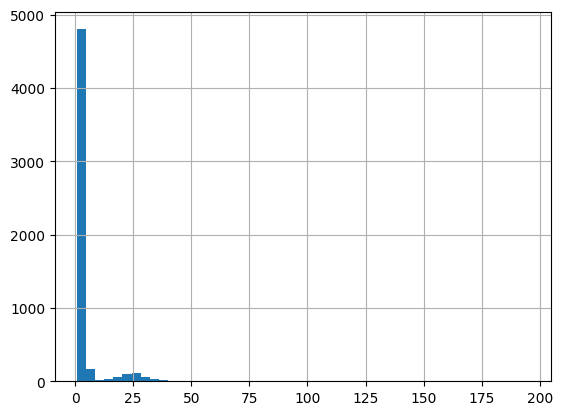

In [9]:
convdf[convdf['convo_end']==False]['human_length'].hist(bins=50)

In [10]:
row_id = np.random.choice(np.arange(len(data)), size=1)[0]
use_cols = ['human', 'assistant', 'id', 'parent_id', 'row_id', 'convo_end', 'human_length']
print(convdf[convdf['row_id']==row_id][use_cols].shape)
convdf[convdf['row_id']==row_id][use_cols]

(7, 7)


,human,assistant,id,parent_id,row_id,convo_end,human_length
3218,Hi,Hi,conv0511_item00,None,511,False,2
3219,Hi,"In the bustling city of Sigil, the nexus of the multiverse, you find yourself standing at the crossroads of countless realities. The air buzzes with the energy of a thousand worlds, each portal promising adventure and mystery. As you take in the sights and sounds of this hub of planar travel, a cloaked figure approaches you with an offer to join one of three expeditions. Each promises to explore a different and unique plane of existence. Which do you choose?\n\nA) **The Elemental Plane of Fire**: A daring mission to retrieve a legendary artifact from the heart of a volcano, surrounded by rivers of lava and inhabited by fierce fire elementals and phoenixes. The heat is unbearable, and the journey is perilous, but the artifact is said to hold the power to control the very essence of flame.\n\nB) **The Plane of Faerie**: A mystical journey into an enchanted forest filled with whimsical creatures, ancient magic, and unpredictable trickery. The beauty of the plane is unparalleled, hidin...",conv0511_item01,conv0511_item00,511,False,2
3220,B) **The Plane of Faerie**,"As you step through the portal to the Plane of Faerie, the world around you transforms. The air sparkles with magic, and the forest greets you with a kaleidoscope of colors and sounds. The flora and fauna seem to watch with curious eyes, and the path ahead is lit by floating will-o'-wisps that guide your steps. Your mission to broker peace between the two feuding faerie courts is a delicate one, requiring both wit and wisdom.\n\nAs you journey deeper into the enchanted forest, you come across a trio of challenges set by the faerie folk to test your worthiness. Which challenge do you choose to tackle first?\n\nA) **The Riddle of the Ancient Oak**: A wise but mischievous dryad presents you with a riddle that has stumped many travelers. Solving it will earn you the respect of the forest's inhabitants and the attention of the faerie courts.\n\nB) **The Trial of Trickery**: A group of pixies invites you to a game of wits and deception. Winning their game will prove your cleverness and e...",conv0511_item02,conv0511_item01,511,False,26
3221,C,"Venturing through the dense, whispering foliage, you follow the faint, sorrowful echoes that guide you deeper into the heart of the enchanted forest. The melody, though fragmented, tugs at your soul, a haunting reminder of beauty lost. Eventually, you find the melancholy siren perched beside a crystal-clear stream, her eyes brimming with unshed tears.\n\nWith determination, you embark on a quest to retrieve the lost melody. Your journey leads you through hidden glens and secret groves, each step guided by the fragments of song carried on the wind. Along the way, you encounter a series of choices that will determine the success of your quest.\n\nWhich approach do you take to recover the lost melody?\n\nA) **Seek the Wisdom of the Forest**: You decide to consult the ancient beings of the forest, from the whispering trees to the wise old creatures that dwell within. Their age-old wisdom might hold the key to uncovering the melody's resting place.\n\nB) **Follow the Song's Essence**: T...",conv0511_item03,conv0511_item02,511,False,1
3222,B,"Trusting in your intuition and the emotional resonance of the lost melody, you allow the ethereal fragments of song to guide you. The deeper into the forest you venture, the stronger the melody becomes, tugging at your heart with a mixture of joy and sorrow. You navigate through the woods as if in a trance, led by the haunting beauty of the siren's song.\n\nAs you journey, the melody leads you to a secluded glade bathed in moonlight. In the center, a crystal pond reflects the stars above, and hovering above the water, you see the shimmering essence of the lost melody. It dances in the air, a symphony of light and sound, fragmented yet whole. With care and patience, you reach out to the melody,

In [18]:
print(convdf.loc[3224]['human'])

B
**I have already given the answer to the last question. Please give MBTI and the corresponding role and the corresponding reasons.**


In [265]:
convdf.to_parquet('../feature_data/clean_conversation_v0.parquet')

# create data with alternative sys prompt

In [12]:

def read_file_into_list(file):
    lines = []
    # Open the file and read line by line
    with open(file, 'r') as file:
        for line in file:
            # Append each line to the list, stripping the newline characters
            lines.append(line.strip())
    return lines

In [15]:
sp1 = """
D&D Characters and MBTI Types:

Acolyte (INFJ): Introverted and deeply religious, serving as a bridge between the divine and the mortal.
Court Servant (ISFJ): Former servant with keen social insights, respectful of tradition.
Desert Runner (ISTP): Nomadic survivor of harsh environments, feels at home in the desert.
Destined (ENFJ): Noble with burdensome responsibilities, seeks to fulfill or escape destiny.
Diplomat (ENFP): Mediator of conflicts, persuasive and friendly.
Forest Dweller (ISFP): Solitary and connected to nature, cautious of outsiders.
Former Adventurer (ESTJ): Experienced and resilient leader, seeking new challenges.
Freebooter (ESTP): Energetic pirate accustomed to maritime life, loves freedom.
Gamekeeper (ISTJ): Skilled hunter and conservationist, pragmatic.
Innkeeper (ESFJ): Sociable inn or tavern owner, enjoys sharing stories.
Mysterious Origins (INFP): Amnesiac exploring fragments of their past, enthusiastic about life.
Occultist (INTP): Seeker of hidden truths and mysteries, drawn to esoteric knowledge.
Parfumier (INTJ): Educated perfumer and botanist, rational and ambitious.
Trophy Hunter (ENTJ): Big game hunter, confident and seeking to mentor others.
Northern Minstrel (ENTP): Adventurous bard from the north, cherishes freedom.
Monstrous Adoptee (ESFP): Raised by a creature considered monstrous, unique perspective on survival.

Game Mechanic:

You will engage in a series of five interconnected multiple-choice questions as part of the game narrative. These questions are designed to unfold a vivid storyline that doesn't explicitly mention MBTI elements. At the end of the fifth question, based on your choices throughout the game, your MBTI type will be revealed along with the corresponding D&D character role that best matches your personality.
"""

In [13]:
data = pd.read_parquet('../feature_data/clean_conversation_v0.parquet')

In [16]:
data['system'] = sp1

In [17]:
data.to_parquet('../feature_data/clean_conversation_sp1.parquet')

# check b3 data

In [19]:
d3 = pd.read_parquet('../feature_data/task1/clean_conversation_v0_b_3.parquet')

In [21]:
print(d3['system'].values[0])


You are a game planner, you will conduct a series of questions and answers and interactions with testers based on 'Dungeons & Dragons' to reveal their MBTI personality type. Here are the game characters and their personality traits:
1. Acolyte, INFJ: Raised in a religious temple, serves as a leader, performing sacred rituals and bridging the divine and mortal realms. Introverted, insightful, deeply committed to faith, seeks meaning in religious communities.
2. Court Servant, ISFJ: Once serving a high-status individual, knowledgeable in court customs, now displaced due to master's retirement or dissatisfaction. Reticent yet observant, offers unique social insights with humility and respect for tradition.
3. DESERT RUNNER, ISTP: Nomadic upbringing in the desert fosters survival skills and tribal traditions. Friendly yet warlike, feels at home in the wilderness, wary of city life's constraints.
4. DESTINED, ENFJ: Burdened by complex responsibilities, journeys to embrace or evade destiny.